## Single-layer Territory Management. Optimizing territories considering only clients

In territory management, a territory is a customer group or geographic area over which either an individual salesperson or a sales team has responsibility. These territories are usually defined based on geography, sales potential, number of clients or a combination of these factors.

The main complexity in territory management is to create areas that are balanced with regards to more than one factor that usually behave very differently. There is no one-size-fits-all solution, and if the balance is off, sales management is likely to leave someone within their organization unhappy or leave money on the table. This is why it is very important to identify and understand all the components and requirements of your use case to apply the most appropriate technique.

We can differentiate between two main use cases: when the location of sales reps is important (usually because they have to travel to visit their clients) and when it is not (travel rarely occurs). The first case is clearly more complex than the latter.

In this notebook we will use two different techniques to solve territory management problems when only the location of clients needs to be considered, i.e., we will have a single layer of data consisting of client locations. We will prove the value Spatial Data Science techniques by showing their additional value compared to traditional techniques.

### Use case description

A pharma lab is interested in balancing their sales territories in the state of Texas based on the number of current and potential clients per territory. 

Their clients are mainly offices and clinics of medical doctors.

They are interested in creating 5 balanced territories.

We will use the following two datasets from [CARTO's Data Observatory](https://carto.com/spatial-data-catalog/):
- Points of Interest (POIs). In particular, office and clinic of medical doctors POIs. We will use [Pitney Bowes POI-Consumer dataset](https://carto.com/spatial-data-catalog/browser/dataset/pb_consumer_po_62cddc04/).
- Texas boundary geometry. We'll use [Who's on First GeoJSON - Global dataset](https://carto.com/spatial-data-catalog/browser/geography/wof_geojson_4e78587c/).

*Note* the POI dataset is premium and a subscription is needed to access this data.

### 0. Setup

We'll start by importing all packages we'll use.

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from cartoframes.auth import set_default_credentials
from cartoframes.data.observatory import *
from cartoframes.viz import *
from h3 import h3
from libpysal.weights import Rook
from shapely import wkt
from shapely.geometry import mapping, Polygon
from sklearn.cluster import KMeans
from spopt.region.maxp import MaxPHeuristic

pd.set_option('display.max_columns', None)
plt.rc('axes', titlesize='large')
plt.rc('xtick', labelsize='large')
plt.rc('ytick', labelsize='large')
sns.set_style('whitegrid')

In order to be able to use the Data Observatory via CARTOframes, you need to set your CARTO account credentials first.

Please, visit the [Authentication guide](https://carto.com/developers/cartoframes/guides/Authentication/) for further detail.

In [2]:
set_default_credentials('creds.json')

#### 0.1. Functions

The following function creates an [H3](https://eng.uber.com/h3/) polyfill of the polygon and at the resolution indicated.

In [3]:
def create_h3_grid(polygon, resolution=8):
    hex_id_list = list(h3.polyfill(geojson = mapping(polygon), res = resolution, geo_json_conformant=True))
    hexagon_list = list(map(lambda x : Polygon(h3.h3_to_geo_boundary(h=x, geo_json=True)), hex_id_list))
    grid = pd.DataFrame(data={'hex_id':hex_id_list, 'geometry':hexagon_list})
    grid = gpd.GeoDataFrame(grid, crs='epsg:4326')
    return grid

The function below is used throughout the analysis to check is clusters are balanced based on different metrics.

The function arguments are:
- `cluster_names` so that we can provide descriptive names to clusters
- `areas_df` is the GeoDataFrame
- `groupby` is the column with the cluster to which each cell belongs to
- `**kaggregations` for the different metrics we'd like to calculate

In [4]:
def plot_clinic_balance(clusters, areas_df, groupby, **kaggregations):
    areas_df_g = areas_df.groupby(groupby).agg(kaggregations).reset_index()

    n_plots = len(kaggregations)
    fig, axs = plt.subplots(1, n_plots, figsize=(9 + 3*n_plots,4))
    if n_plots == 1:
        axs = [axs]
    
    for i in range(n_plots):
        sns.barplot(y=groupby, x=list(kaggregations.keys())[i], data=areas_df_g, order=clusters, 
                    palette=['#7F3C8D','#11A579','#3969AC','#F2B701','#E73F74'], ax=axs[i])
        axs[i].set_xlabel(list(kaggregations.keys())[i], fontsize=13)
        axs[i].set_ylabel('Sales rep locations', fontsize=13)
    
    fig.tight_layout()
    
    return axs

### 1. Download and visualize data

Next, we will download the data described in the usecase using [CARTOframes](https://carto.com/developers/cartoframes/).

*Note* in this notebook some prior knowledge on how to explore and download data from the [Data Observatory](https://carto.com/spatial-data-catalog/) is assumed. If this is your first time exploring and downloading data from the [Data Observatory](https://carto.com/spatial-data-catalog/), take a look at [CARTOframes Guides](https://carto.com/developers/cartoframes/guides/Introduction/) and the [Data Observatory examples](https://carto.com/developers/cartoframes/guides/Data-Observatory/) and **discover how easy it is to get started!**

#### 1.1 Texas boundary geometry

We are interested in the geometry of the state of Texas. We'll download it from [Who's on First GeoJSON - Global dataset](https://carto.com/spatial-data-catalog/browser/geography/wof_geojson_4e78587c/).

In [5]:
wof_grographies = Geography.get('wof_geojson_4e78587c')
wof_grographies.to_dict()

{'slug': 'wof_geojson_4e78587c',
 'name': 'GeoJSON - Global',
 'description': "The main table in Who's On First. Holds all the relevant information for a place in the 'body' JSON field.",
 'country_id': 'glo',
 'provider_id': 'whos_on_first',
 'geom_type': 'MULTIPLE',
 'update_frequency': None,
 'is_public_data': True,
 'lang': 'eng',
 'version': '20190520',
 'provider_name': "Who's On First",
 'id': 'carto-do-public-data.whos_on_first.geography_glo_geojson_20190520'}

In [44]:
state_name = 'Texas'
country_code = 'US'
placetype = 'region'

sql_query = f"""SELECT * 
                FROM $geography$ 
                WHERE name = '{state_name}' AND 
                      country = '{country_code}' AND 
                      placetype='{placetype}'"""

tx_boundary = wof_grographies.to_dataframe(sql_query=sql_query)
tx_boundary.crs = 'epsg:4326'
tx_boundary['geom'] = tx_boundary.simplify(0.01)
tx_boundary

,geoid,id,body,name,country,parent_id,is_current,placetype,geometry_type,bbox,geom,lastmodified,lastmodified_timestamp
0,85688753,85688753,"{""id"": 85688753, ""type"": ""Feature"", ""propertie...",Texas,US,85633793,1,region,Polygon,"POLYGON((-93.508039 25.837164, -93.508039 36.5...","POLYGON ((-103.06466 32.95910, -103.06442 32.0...",1555446728,2019-04-16 20:32:08+00:00


#### 1.2. Client locations

We'll download all POIs in Texas classified as "OFFICES AND CLINICS OF MEDICAL DOCTORS" from [Pitney Bowes POI-Consumer dataset](https://carto.com/spatial-data-catalog/browser/dataset/pb_consumer_po_62cddc04/).

*Note* this is a premium dataset and a subscription is required.

In [7]:
poi_dataset = Dataset.get('pb_consumer_po_62cddc04')

In [8]:
sql_query = """
    SELECT * except(do_label) FROM $dataset$ 
    WHERE SUB_CLASS = 'OFFICES AND CLINICS OF MEDICAL DOCTORS' 
    AND STABB = 'TX'
    AND CAST(do_date AS date) >= (SELECT MAX(CAST(do_date AS date)) from $dataset$)
"""
pois = poi_dataset.to_dataframe(sql_query=sql_query)
pois.columns = list(map(str.lower, pois.columns))
pois.crs = 'epsg:4326'
pois.head()

/Users/malvarez/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DtypeWarning: Columns (6,10,27,44,48,49,50,51,52,53,55,56,57,58,59,61,62,63,64,65,66,67,68) have mixed types.Specify dtype option on import or set low_memory=False.
  import sys


,geoid,do_date,name,brandname,pb_id,trade_name,franchise_name,iso3,areaname4,areaname3,areaname2,areaname1,stabb,postcode,formattedaddress,mainaddressline,addresslastline,longitude,latitude,georesult,confidence_code,country_access_code,tel_num,faxnum,email,http,open_24h,business_line,sic1,sic2,sic8,sic8_description,alt_industry_code,micode,trade_division,group,class,sub_class,employee_here,employee_count,year_start,sales_volume_local,sales_volume_us_dollars,currency_code,agent_code,legal_status_code,status_code,subsidiary_indicator,parent_business_name,parent_address,parent_street_address,parent_areaname3,parent_areaname1,parent_country,parent_postcode,domestic_ultimate_business_name,domestic_ultimate_address,domestic_ultimate_street_address,domestic_ultimate_areaname3,domestic_ultimate_areaname1,domestic_ultimate_postcode,global_ultimate_indicator,global_ultimate_business_name,global_ultimate_address,global_ultimate_street_address,global_ultimate_areaname3,global_ultimate_areaname1,global_ultimate_country,global_ultimate_postcode,family_members,hierarchy_code,ticker_symbol,exchange_name,geom
0,1128750296#-96.398536#32.469934,2020-08-01,SIMMONS & ASSOC SOUTH CENTRAL LLC,NaN,1128750296,SIMMONS & ASSOCIATES,NaN,USA,NaN,SCURRY,NaN,TEXAS,TX,75158-3304,"9084 FM 2451, SCURRY, TX, 75158-3304",9084 FM 2451,"SCURRY, TX, 75158-3304",-96.398536,32.469934,S8HPNTSCZA,HIGH,1.0,(972) 452-8013,NaN,NaN,WWW.SIMMONSINC.COM,NaN,"OFFICES AND CLINICS MEDICAL DOCTORS,NSK",8011.0,NaN,80110000,OFFICES AND CLINICS OF MEDICAL DOCTORS,621111.0,10238011,DIVISION I. - SERVICES,HEALTH SERVICES,OFFICES AND CLINICS OF DOCTORS OF MEDICINE,OFFICES AND CLINICS OF MEDICAL DOCTORS,1.0,1.0,1997.0,251657.0,251657.0,20.0,G,3.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,POINT (-96.39854 32.46993)
1,1217171653#-96.858002#32.715481,2020-08-01,SOUTHWEST DALLAS ORTHOPEDIC ASSOCIATES,NaN,1217171653,NaN,NaN,USA,NaN,DALLAS,NaN,TEXAS,TX,75224-3059,"2909 S HAMPTON RD STE D121, DALLAS, TX, 75224-...",2909 S HAMPTON RD STE D121,"DALLAS, TX, 75224-3059",-96.858002,32.715481,S8HPNTSCZA,HIGH,1.0,(214) 333-3741,NaN,NaN,WWW.DALLASORTHO.COM,NaN,"OFFICES AND CLINICS MEDICAL DOCTORS,NSK",8011.0,NaN,80110514,ORTHOPEDIC PHYSICIAN,621111.0,10942514,DIVISION I. - SERVICES,HEALTH SERVICES,OFFICES AND CLINICS OF DOCTORS OF MEDICINE,OFFICES AND CLINICS OF MEDICAL DOCTORS,6.0,6.0,1991.0,620608.0,620608.0,20.0,G,13.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,POINT (-96.85800 32.71548)
2,1123005494#-97.104542#32.926825,2020-08-01,S ROBERT HARLA DOPA,NaN,1123005494,GRAPEVINE DERMATOLOGY,NaN,USA,NaN,GRAPEVINE,NaN,TEXAS,TX,76051-8632,"2321 IRA E WOODS AVE STE 180, GRAPEVINE, TX, 7...",2321 IRA E WOODS AVE STE 180,"GRAPEVINE, TX, 76051-8632",-97.104542,32.926825,S8HPNTSCZA,HIGH,1.0,(817) 329-2263,NaN,NaN,WWW.DERMDFW.COM,NaN,"OFFICES AND CLINICS MEDICAL DOCTORS,NSK",8011.0,NaN,80110503,DERMATOLOGIST,621111.0,10942503,DIVISION I. - SERVICES,HEALTH SERVICES,OFFICES AND CLINICS OF DOCTORS OF MEDICINE,OFFICES AND CLINICS OF MEDICAL DOCTORS,13.0,13.0,1990.0,1345253.0,1345253.0,20.0,G,13.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,POINT (-97.10454 32.92683)
3,1221252299#-101.902112#33.573453,2020-08-01,CONSULTANTS IN INFECTIOUS DISEASES LLP,NaN,1221252299,NaN,NaN,USA,NaN,LUBBOCK,NaN,TEXAS,TX,79410-1804,"4102 24TH ST STE 403, LUBBOCK, TX, 79410-1804",4102 24TH ST STE 403,"LUBBOCK, TX, 79410-1804",-101.902112,33.573453,S8HPNTSCZA,HIGH,1.0,(806) 725-7150,NaN,NaN,WWW.COVMEDGROUP.ORG,NaN,"OFFICES AND CLINICS MEDICAL DOCTORS,NSK",8011.0,NaN,80110510,"INFECTIOUS DISEASE SPECIALIST, PHYSICIAN/SURGEON",621111.0,10942510,DIVISION I. - SERVICES,HEALTH SERVICES,OFFICES AND CLINICS OF DOCTORS OF MEDICINE,OFFICES AND CLINICS OF MEDICAL DOCTORS,22.0,22.0,1995.0,1058845.0,1058845.0,20.0,G,12.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [9]:
pois.shape

(59554, 74)

#### 1.3 Visualize data

In [35]:
Map([Layer(tx_boundary, geom_col='geom',
           style=basic_style(opacity=0, stroke_color='#11A579', stroke_width=5),
           legends=basic_legend('Texas Boundary')),
     Layer(pois.sample(5000), 
           style=basic_style(color='#F2B701', size=2, opacity=0.9, stroke_width=0),
           popup_hover=[popup_element('name', 'Client'),
                        popup_element('employee_here', '# Employees')],
           legends=basic_legend('Client Locations'))], 
    basemap=basemaps.darkmatter)

### 2. Discretize space. H3 grid

A fundamental step in territory management is to discretize space. Territory management algorithms are computationally complex and hence it is crucial to leverage the spatial component to reduce complexity. We can do this by working at an aggregated level instead of considering each client location independently.

We first need to identify the smallest spatial aggregation that makes sense for your business, our **geographic support**. This can be census block groups, zip codes or counties, or you can be interested in using a standard grid, in which case it would ideally be a hierarchical spatial index such as [Quadkey grid](https://docs.microsoft.com/en-us/azure/azure-maps/zoom-levels-and-tile-grid?tabs=csharp) or [H3 grid](https://eng.uber.com/h3/).

In this notebook we will use an H3 grid of resolution 4. We can easily discretize space by performing a polyfill of the Texas boundary polygon. 

*Note* a buffer has been applied because H3 will fill the polygon with all hexagons of resolution 4 whose centroid lies within the polygon to be filled and we want to make sure the whole territory is covered.

In [46]:
# Buffer
buffer = 2.5e4  # in meters
tx_boundary['geometry_buffer'] = tx_boundary.to_crs('epsg:26914').buffer(buffer).to_crs('epsg:4326')

grid = create_h3_grid(tx_boundary['geometry_buffer'].iloc[0], 4)
grid.head()

,hex_id,geometry
0,8426c81ffffffff,"POLYGON ((-96.74717 33.11534, -96.49922 33.244..."
1,8426d59ffffffff,"POLYGON ((-100.92381 36.33036, -100.66884 36.4..."
2,8448839ffffffff,"POLYGON ((-99.95645 28.45344, -99.71818 28.594..."
3,8448f67ffffffff,"POLYGON ((-104.12891 29.69693, -103.89013 29.8..."
4,8448b3bffffffff,"POLYGON ((-98.31519 26.24470, -98.08110 26.383..."


In [47]:
Map([Layer(grid,
           style=basic_style(opacity=0.75),
           legends=basic_legend('H3 grid')),
     Layer(tx_boundary,
           style=basic_style(opacity=0, stroke_color='#E73F74', stroke_width=5),
           legends=basic_legend('Texas Boundary'))])

#### 2.1. Aggregate client info at the grid level.

We will aggregate clients by:
- Counting the number of clients per cell
- Calculating the median rating of clients within eack cell

In [48]:
pois_g = gpd.sjoin(pois, grid, how='right').groupby('hex_id').agg({'geoid':'count', 'employee_here':'mean'}).\
            reset_index().rename(columns={'geoid':'poi_count', 'employee_here':'employee_avg'})
pois_g[['poi_count', 'employee_avg']] = pois_g[['poi_count', 'employee_avg']].fillna(0)
areas = grid.merge(pois_g, on='hex_id')
areas = gpd.GeoDataFrame(areas, crs='epsg:4326')
areas.head()

,hex_id,geometry,poi_count,employee_avg
0,8426c81ffffffff,"POLYGON ((-96.74717 33.11534, -96.49922 33.244...",646,5.170673
1,8426d59ffffffff,"POLYGON ((-100.92381 36.33036, -100.66884 36.4...",0,0.000000
2,8448839ffffffff,"POLYGON ((-99.95645 28.45344, -99.71818 28.594...",17,5.285714
3,8448f67ffffffff,"POLYGON ((-104.12891 29.69693, -103.89013 29.8...",0,0.000000
4,8448b3bffffffff,"POLYGON ((-98.31519 26.24470, -98.08110 26.383...",26,3.526316


In [49]:
areas['poi_count'].describe(percentiles=[0.25, 0.5, 0.75, 0.95])

count     402.000000
mean      148.144279
std       709.392374
min         0.000000
25%         0.000000
50%         4.000000
75%        40.500000
95%       496.950000
max      8268.000000
Name: poi_count, dtype: float64

In [50]:
breaks=[1, 4, 40, 500]

Map(Layer(areas, 
          style=color_bins_style('poi_count', breaks=breaks),
          legends=color_bins_legend('Number of Clients')))

### 3. Territory Optimization

Once we have our data aggregated, it's time to start working on building balanced territories.

We will explore two different techniques:
- [KMeans clustering](https://en.wikipedia.org/wiki/K-means_clustering).
- [Max-p spatial clustering algorithm](https://region.readthedocs.io/en/latest/users/max-p-regions/). 

#### 3.1 Approach 1. KMeans clustering

This is a very well known and broadly used technique. However, this technique doesn't allow you to incorporate balancing criteria and usually generates low quality results for territory management.

##### 3.1.1. Calculate clusters

In [57]:
no_territories = 5
kmeans = KMeans(no_territories, random_state=1111)

kmeans.fit_predict(list(map(lambda point:[point.x, point.y], areas.to_crs('epsg:26914').centroid)), 
                   sample_weight=areas['poi_count'])
print('Done!')

Done!


##### 3.1.2. Label grid cells

We assign each cell to the cluster it belongs to.

In order to have comparable results with other techniques, we identify 5 representative cells, each of which being far enough from each other to make sure they are in different clusters. This way, we can compare how each cluster changes.

In [58]:
areas['kmeans_cluster'] = kmeans.labels_
areas['kmeans_cluster'] += 1

In [59]:
# This dictionary contains the representative cells with the cluster they represent.
trans_dict={'8448c69ffffffff':1,
            '8426d47ffffffff':2,
            '8426cdbffffffff':3,
            '84446edffffffff':4,
            '844880dffffffff':5}

In [60]:
areas['kmeans_cluster_aux'] = -1
for hex_id in trans_dict:
    areas.loc[areas['kmeans_cluster'] == areas.loc[areas['hex_id'] == hex_id, 'kmeans_cluster'].iloc[0], 'kmeans_cluster_aux'] = trans_dict[hex_id]
areas['kmeans_cluster'] = areas['kmeans_cluster_aux']
areas.drop(columns='kmeans_cluster_aux', inplace=True)

We create a string variable with a more descriptive name for our visualization

In [61]:
areas['kmeans_cluster_cat'] = list(map(lambda v:f'Cluster_{v}', areas['kmeans_cluster']))

##### 3.1.3. Visualize and analyze results

KMeans calculates nice compact clusters (see map). However, we get very unbalanced clusters with Cluster_3 having 10 times more clients than Cluster_1, as can be seen in the chart below.

In [62]:
Map(Layer(areas, 
          style=color_category_style('kmeans_cluster_cat', cat=sorted(areas['kmeans_cluster_cat'].unique())),
          legends=color_category_legend('KMeans Clustering')))

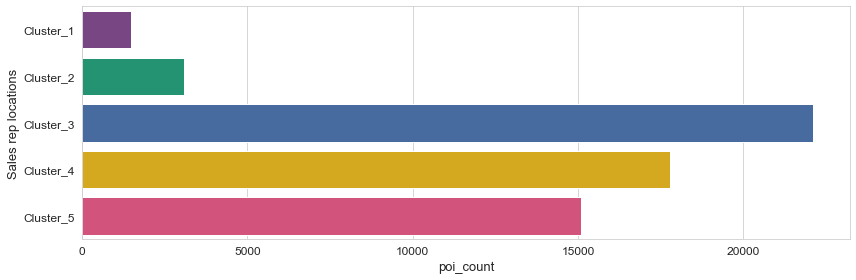

In [63]:
plot_clinic_balance(sorted(areas['kmeans_cluster_cat'].unique()), areas, 'kmeans_cluster_cat', poi_count='sum')

#### 3.2 Approach 2. Max-p

Let's now try to balance the number of clients per cluster while maintaining connected clusters as compact as possible.

We will use [Pysal's implementation of the Max-p algorithm](https://github.com/pysal/spopt). Max-p is a spatial clustering algorithm that calculates spatially connected clusters, with similar properties, while balancing one criterion, or mixed or criteria.

##### 3.2.1. Weights. Adjacency matrix

The first thing we need to do is calculate the adjacency matrix which will tell the algorithm which cells are contiguous.

We will use [Rook weights](https://pysal.org/libpysal/generated/libpysal.weights.Rook.html) which considers two polygons to be contiguous if they share one edge.

In [64]:
wgt = Rook.from_dataframe(areas, geom_col='geometry')

In [65]:
wgt.histogram

[(2, 7), (3, 25), (4, 35), (5, 33), (6, 302)]

##### 3.2.2 Balancing criteria

We would like to balance clusters based on total number of clients. Normally we are not looking for a perfect balance, especially when dealing with more than one multiple criteria, and a balance tolerance is introduced. In our case, we will consider a tolerance of 20%, which means that we allow clusters to be as much as 20% below the perfect balance.

*Note* we are only using the number of clients to balance, but this dataset also has the number of employees per client and you might even have other data you might be interested in using. The good news is Max-p allows you to do that.

In [117]:
# Trick to help the algorithm find compact areas
areas['poi_count'] += 10

In [118]:
balance_tolerance = 0.15  # 15%
perfect_balance = areas['poi_count'].sum()/5
threshold = int(np.floor(perfect_balance * (1-balance_tolerance)))
print('Minimum number of clients per cluster', threshold)

Minimum number of clients per cluster 10807


##### 3.2.3. Similarity criteria

Max-p also allows you to set similarity criteria. These are variables that you want to have a similar behavior **within clusters**. For example, you might be interested in having clusters with similar demographic or socioeconomic characteristics.

In this case, we don't have any specific criteria, so we will use the gris cell centroid coordinates as similarity criteria in order to get clusters as compact as possible. You can try removing these or only adding one of the coordinates to clearly see whats the effect of these similarity criteria.

In [119]:
areas['lat'] = np.array(list(map(lambda point:[point.y, point.x], areas.centroid)))[:,0]
areas['lon'] = np.array(list(map(lambda point:[point.y, point.x], areas.centroid)))[:,1]
areas['lat_norm'] = (areas['lat'] - areas['lat'].min())/(areas['lat'].max() - areas['lat'].min())
areas['lon_norm'] = (areas['lon'] - areas['lon'].min())/(areas['lon'].max() - areas['lon'].min())
areas.head()

,hex_id,geometry,poi_count,employee_avg,kmeans_cluster,kmeans_cluster_cat,lat,lon,lat_norm,lon_norm,maxp_cluster,maxp_cluster_cat
0,8426c81ffffffff,"POLYGON ((-96.74717 33.11534, -96.49922 33.244...",656,5.170673,3,Cluster_3,33.363543,-96.761646,0.699669,0.747609,2,Cluster_2
1,8426d59ffffffff,"POLYGON ((-100.92381 36.33036, -100.66884 36.4...",10,0.000000,2,Cluster_2,36.575315,-100.948479,0.996130,0.433139,2,Cluster_2
2,8448839ffffffff,"POLYGON ((-99.95645 28.45344, -99.71818 28.594...",27,5.285714,5,Cluster_5,28.707359,-99.977361,0.269883,0.506079,-1,Cluster_-1
3,8448f67ffffffff,"POLYGON ((-104.12891 29.69693, -103.89013 29.8...",10,0.000000,1,Cluster_1,29.950792,-104.159207,0.384657,0.191983,5,Cluster_5
4,8448b3bffffffff,"POLYGON ((-98.31519 26.24470, -98.08110 26.383...",36,3.526316,5,Cluster_5,26.498779,-98.332203,0.066021,0.629646,-1,Cluster_-1


##### 3.2.4. Calculate clusters

In [120]:
maxp_heur = MaxPHeuristic(areas, wgt, ['lat_norm', 'lon_norm'], 'poi_count', threshold, 
                          5, max_iterations_construction=2, max_iterations_sa=5, verbose=True)
maxp_heur.solve()

max_p:  5
number of good partitions: 1
0
totalWithinRegionDistance after SA: 
5742.799852971792
totalWithinRegionDistance after SA: 
5867.051106513276
totalWithinRegionDistance after SA: 
5618.855674245072
totalWithinRegionDistance after SA: 
5951.021159585439
totalWithinRegionDistance after SA: 
6051.852214200337
best objective value:
5618.855674245072


In [121]:
np.max(maxp_heur.labels_)

5

In [122]:
# Undo change
areas['poi_count'] -= 10

##### 3.2.5. Label grid cells

We assign each cell to the cluster it belongs to and rename clusters based on the representative cells we mentioned in the KMeans section.

In [123]:
areas['maxp_cluster'] = maxp_heur.labels_

In [124]:
areas['maxp_cluster_aux'] = -1
for hex_id in trans_dict:
    areas.loc[areas['maxp_cluster'] == areas.loc[areas['hex_id'] == hex_id, 'maxp_cluster'].iloc[0], 'maxp_cluster_aux'] = trans_dict[hex_id]
areas['maxp_cluster'] = areas['maxp_cluster_aux']
areas.drop(columns='maxp_cluster_aux', inplace=True)

In [125]:
areas['maxp_cluster_cat'] = list(map(lambda v:f'Cluster_{v}', areas['maxp_cluster']))

##### 3.2.6. Visualize and analyze results

We can see how clusters now are less compact than they were with KMeans, but now clusters are balanced, with all of them satisfying the minimum requirement of 4256 clients per cluster.

In [126]:
Layout([Map(Layer(areas, 
                  style=color_category_style('kmeans_cluster_cat', cat=sorted(areas['kmeans_cluster_cat'].unique())),
                  legends=color_category_legend('KMeans Clustering'),
                  popup_hover=[popup_element('hex_id'), popup_element('maxp_cluster_cat')])),
        Map(Layer(areas, 
                  style=color_category_style('maxp_cluster_cat', cat=sorted(areas['maxp_cluster_cat'].unique())),
                  legends=color_category_legend('Max-p Clustering'),
                  popup_hover=[popup_element('hex_id'), popup_element('maxp_cluster_cat')]))
        ], map_height=400)

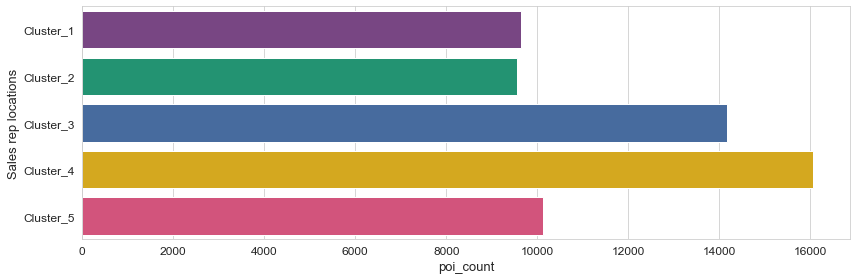

In [127]:
plot_clinic_balance(sorted(areas['maxp_cluster_cat'].unique()), areas, 'maxp_cluster_cat', poi_count='sum')